# Bank Classification

Los datos están relacionados con una campaña de marketing directo de una institución bancaria portuguesa. Las campañas de marketing se basaban en llamadas telefónicas. A menudo, se requería más de un contacto con el mismo cliente, para saber  si el producto (depósito bancario a plazo) sería  ('sí') o no ('no') suscrito. La descripción de la base de  datos se puede encontrar en el fichero **bank_names.txt**.


* **Datos de los clientes del banco**
    * **age**
    * **job**: tipo de trabajo (categórico)
    * **marital**: estado civil (categórico)
    * **education** (categórico)
    * **default**: has credit in default? (binario)
    * **balance**: media del balance anual en euros (numérico)
    * **housing**: ¿tiene un préctamo de vivienda? (binario)
    * **loan**: ¿tiene un préstamo personal? (binario)
   
* **Variables relacionadas con el último contacto de la actual campaña**
    * **contact**: tipo de contacto (categórico: "unknown","telephone","cellular") 
    * **day**: último día de contacto del mes (numérico)
    * **month**: último mes de contacto del mes (categórico)
    * **duration**: última duración del contacto es segundos (numérico)
  
* **Otros atributos**
    * **campaign**: número de contactos realizados durante esta campaña y para este cliente (numérico)
    * **pdays**: número de días que han pasado desde que el cliente fue contactado por última vez en una campaña anterior (numérico. -1 quiere decir que el cliente no fue previamente contactado)
    * **previous**: número de contactos realizados antes de esta campaña y para este cliente (numérico)
    * **poutcome**: resultado de la campaña de marketing previa (categórico)

* **Variable objectivo**
    * **y**: ¿se ha suscrito el cliente al depósito? (binario)
    
<br>

<div class="panel panel-success">
    <div class='panel-heading'>
        <h2>Índice</h2>
    </div>
    <div class='panel-body'>
        <ol type="A">
            <li><a href="#carga">Carga de datos</a></li>
            <li><a href="#analisis">Análisis exploratorio de datos</a></li>
                <ol type="B">
                    <li><a href="#analisis-continuas">Análisis de variables continuas</a></li>
                    <li><a href="#analisis-descriptivas">Análisis de variables descriptivas</a></li>
                    <li><a href="#feature-importance">Test Chi Square y Feature Importance</a></li>
                </ol>
            <li><a href="#seleccion-datos">Selección del conjunto de datos final</a></li>
                <ol type=B>
                    <li><a href=#balance>Balanceamiento de clases</a></li>
                </ol>
            <li><a href="#train-test">Separación de datos de entrenamiento y prueba</a></li>
            <li><a href=#knn>K-Nearest Neighbors Classifier</a></li>
            <li><a href=#regresion-logistica>Regresión logística</a></li>
            <li><a href=#arbol-decision>Árboles de decisión</a></li>
                <ol type=B>
                    <li><a href=#arbol-decision-basico>Árbol de decisión básico</a></li>
                    <li><a href=#arbol-decision-gs>Árbol de decisión mediante GridSearchCV</a></li>
                    <li><a href=#arbol-decision-visualizacion>Visualización de las variables más importantes</a></li>
                </ol>
            <li><a href=#random-forest>Random Forest</a></li>
                <ol type=B>
                   <li><a href=#random-forest-visualizacion>Visualización de las variables más importantes</a></li>
                </ol>
            <li><a href=#svm>SVM</a></li>
                <ol type=B>
                    <li><a href=#svm-lineal>SVM con Kernel lineal</a></li>
                    <li><a href=#svm-rbf>SVM con Kernel RBF</a></li>
                    <li><a href=#svm-poly>SVM con Kernel polinomial</a></li>
                    <li><a href=#svm-result>Conclusiones de SVM</a></li>
                </ol>
            <li><a href=#neural-net>Redes neuronales</a></li>
            <li><a href=#conclusiones>Conclusiones</a></li>
        </ol>
    </div>
</div>

# 1. Carga de los datos <a class="anchor" id="carga"></a>

Se realiza una carga de las librerías necesarias para este proyecto.

In [58]:
import os
import glob
import math

import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 80)

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

import seaborn as sns

from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

<br>
Se lee el fichero CSV **bank-dataset** para cargar los datos en un dataframe de Pandas.

In [59]:
df = pd.read_csv("bank-dataset.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# 2. Análisis exploratorio de los datos <a class="anchor" id="analisis"></a>

<br>
El conjunto de datos se compone por 45.211 registros y 17 columnas.

In [60]:
df.shape

(45211, 17)

### Variables binarias

Las variables binarias **y**, **loan**, **housing** y **default**, cuyos valores están como **yes** y **no**, se sustituyen por 1 y 0, respectivamente.

In [61]:
binary_col_list = ['y', 'loan', 'housing', 'default']
df[binary_col_list].apply(lambda x: x.value_counts())

,y,loan,housing,default
no,39922,37967,20081,44396
yes,5289,7244,25130,815


In [62]:
df[binary_col_list] = df[binary_col_list].apply(lambda x: x.map(dict(yes=1, no=0)))
df[binary_col_list].apply(lambda x: x.value_counts())

,y,loan,housing,default
0,39922,37967,20081,44396
1,5289,7244,25130,815


<br>
La variable objetivo **y** tiene 39.922 registros con valor 0 y 5289 registros con valor 1. Esto resulta en una proporción del 7.54%. A pesar de que no es un desbalanceamiento extremo, como podría ser un 2% o 3%, se podrían tomar medidas de balanceamiento como, por ejemplo, **upsampling** o **downsampling**, pero no es el objetivo de este proyecto estudiar este tipo de técnicas.

<br>
Los tipos de las columnas del dataframe son los siguientes:

In [63]:
df.dtypes

age           int64
job          object
marital      object
education    object
default       int64
balance       int64
housing       int64
loan          int64
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

<br>
A continuación, se muestra las estadísticas descriptivas de cada columna que resume la tendencia, dispersión y forma de la distribución del conjunto de datos, excluyendo los valores nulos.

In [64]:
df.describe()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,0.018027,1362.272058,0.555838,0.160226,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,0.133049,3044.765829,0.496878,0.366820,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,72.000000,0.000000,0.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,0.000000,448.000000,1.000000,0.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,0.000000,1428.000000,1.000000,0.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


<br>
Lo que se puede apreciar es que la variable **balance** tiene valores muy dispersos, estando la media y los cuartiles muy alejados de los valores máximos y mínimos. Es posible que tenga outliers y se tengan que eliminar.

La variable **duration** también es posible que tenga algún outlier debido a que su valor máximo está muy alejado del valor medio.

La variables se tendrán que normalizar para que todas estén en la misma escala cuando se entrenen los modelos.

<br>
A continuación, se analizan las variables una a una para hacer cambios sobre ellas en caso de que sea necesario.

### Variable "job"

In [65]:
df.job.value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

<br>
Algunas categorías de la variable **job** pueden unirse y, de esta forma, reducir el número de estas. Esto nos beneficiara, en el caso de usarse, en reducir el número de variables que empleen para entrenar los modelos, debido a que se tendrán que crear variables **dummies**.

De esta forma, **management** y **admin.** se unirán en una categoría llamada **administration**, **services** y **housemaid** en una llamada **services**, y **retired**, **student**, **unemployed** y **unknown** en una llama **other**.

In [66]:
df['job'] = df.job.replace(['management', 'admin.'], 'administration')
df['job'] = df.job.replace(['services', 'housemaid'], 'services')
df['job'] = df.job.replace(['retired', 'student', 'unemployed', 'unknown'], 'other')

In [67]:
df.job.value_counts()

administration    14629
blue-collar        9732
technician         7597
services           5394
other              4793
self-employed      1579
entrepreneur       1487
Name: job, dtype: int64

### Variable "marital"

In [68]:
df.marital.value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

### Variable "education"

In [69]:
df.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

### Variable "contact"

In [70]:
df.contact.value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

### Variable "month"

In [71]:
df.month.value_counts()

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

### Variable "pdays"

In [72]:
df.loc[df.pdays == -1, 'pdays'].count() / len(df)

0.81736745482294137

<br>
El 81% de los registros de la variable **pdays** es -1, lo cual quiere decir que el cliente nunca fue contactado anteriormente. Por lo tanto, la variable **poutcome** también tendrá el valor *unknown* un 81% de las veces, al igual que la variable **previous** con el valor 0.

In [73]:
print(df.loc[df.poutcome == 'unknown', 'poutcome'].count() / len(df))
print(df.loc[df.previous == 0, 'previous'].count() / len(df))

0.817478047378
0.817367454823


### Variable "poutcome"

In [74]:
df.poutcome.value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

<br>
La categoría **unknown** puede unirse con la categoría **other** debido a que, prácticamente, nos da la misma información.

In [75]:
df['poutcome'] = df.poutcome.replace(['unknown'], 'other')

In [76]:
df.poutcome.value_counts()

other      38799
failure     4901
success     1511
Name: poutcome, dtype: int64

### Variable "duration"

Pasamos los segundos a minutos.

In [77]:
df['duration'] = df.duration / 60

### Valores nulos

A continuacón, se demuestra que no hay ningún valor nulo en el dataset.

In [78]:
null_data = df.isnull().mean()
null_data.sort_values(ascending=False)

y            0.0
loan         0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
contact      0.0
poutcome     0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
age          0.0
dtype: float64

### Correlación entre variables

In [79]:
corr = df.corr()
corr

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
age,1.000000,-0.017879,0.097783,-0.185513,-0.015655,-0.009120,-0.004648,0.004760,-0.023758,0.001288,0.025155
default,-0.017879,1.000000,-0.066745,-0.006025,0.077234,0.009424,-0.010021,0.016822,-0.029979,-0.018329,-0.022419
balance,0.097783,-0.066745,1.000000,-0.068768,-0.084350,0.004503,0.021560,-0.014578,0.003435,0.016674,0.052838
housing,-0.185513,-0.006025,-0.068768,1.000000,0.041323,-0.027982,0.005075,-0.023599,0.124178,0.037076,-0.139173
loan,-0.015655,0.077234,-0.084350,0.041323,1.000000,0.011370,-0.012412,0.009980,-0.022754,-0.011043,-0.068185
day,-0.009120,0.009424,0.004503,-0.027982,0.011370,1.000000,-0.030206,0.162490,-0.093044,-0.051710,-0.028348
duration,-0.004648,-0.010021,0.021560,0.005075,-0.012412,-0.030206,1.000000,-0.084570,-0.001565,0.001203,0.394521
campaign,0.004760,0.016822,-0.014578,-0.023599,0.009980,0.162490,-0.084570,1.000000,-0.088628,-0.032855,-0.073172
pdays,-0.023758,-0.029979,0.003435,0.124178,-0.022754,-0.093044,-0.001565,-0.088628,1.000000,0.454820,0.103621
previous,0.001288,-0.018329,0.016674,0.037076,-0.011043,-0.051710,0.001203,-0.032855,0.454820,1.000000,0.093236


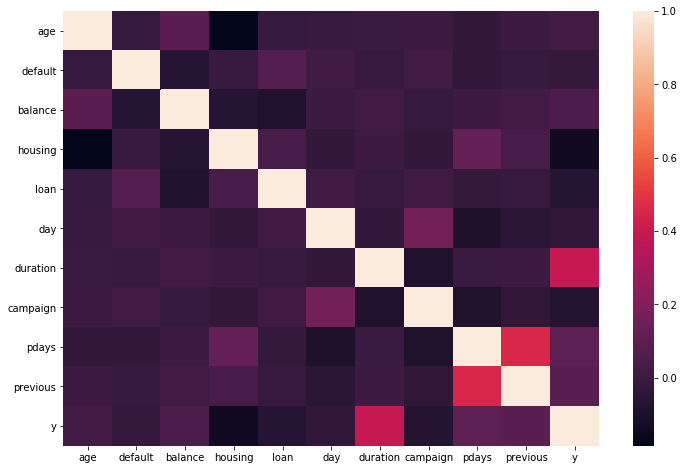

In [80]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Hay que tener en cuenta que la medida de correlación se debe hacer para variables continuas.

En general, no existe ningún par de variables con una alta correlación. La variables más correlacionadas son **pdays** y **previous**.

##  2.1. Análisis de variables continuas <a class="anchor" id="analisis-continuas"></a>

Las variables continuas a analizar son **age**, **balance**, **day**, **duration**, **pdays**, **previous** y **campaign**.

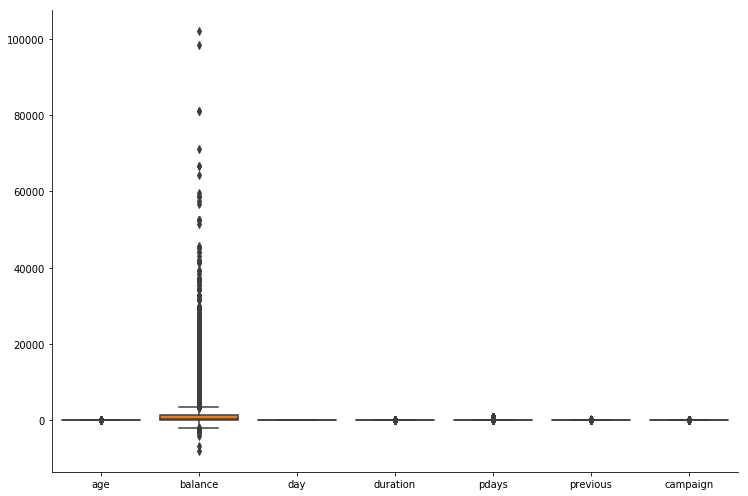

In [81]:
continuous_feature_list = ['age', 'balance', 'day', 'duration', 'pdays', 'previous', 'campaign']

sns.factorplot(kind='box',
               data=df[continuous_feature_list],
               size=7,
               aspect=1.5,
               legend_out=False)

<br>
Con los diagramas de cajas anteriores, podemos ver como la variable **balance** es la que más dispersión en los datos tiene y cuyos valores sobrepasan mucho sobre su mediana, como ya hemos comentado anteriormente. Dado que no es posible analizar todas las variables en esta escala, a continuación se crea un diagrama de cajas para cada variable separando los datos por la variable objetivo **y** para poder analizar cómo afecta cada una de las variables a la objetivo.

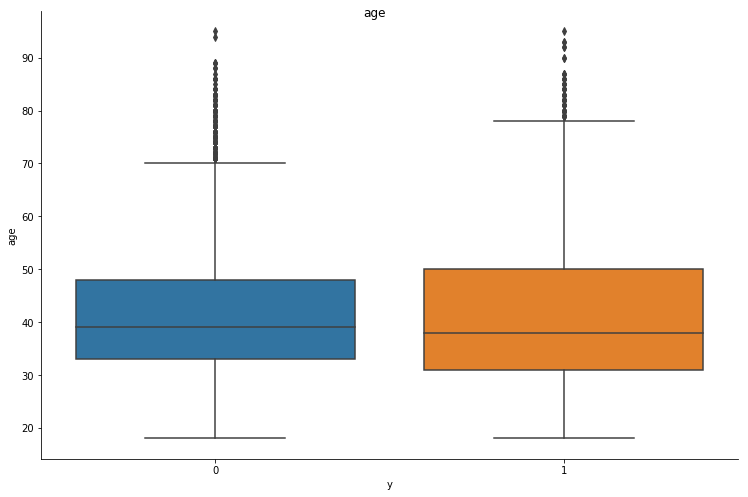

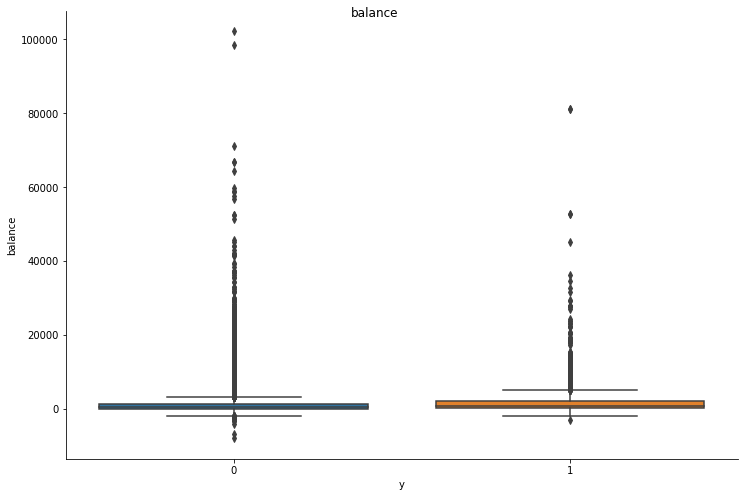

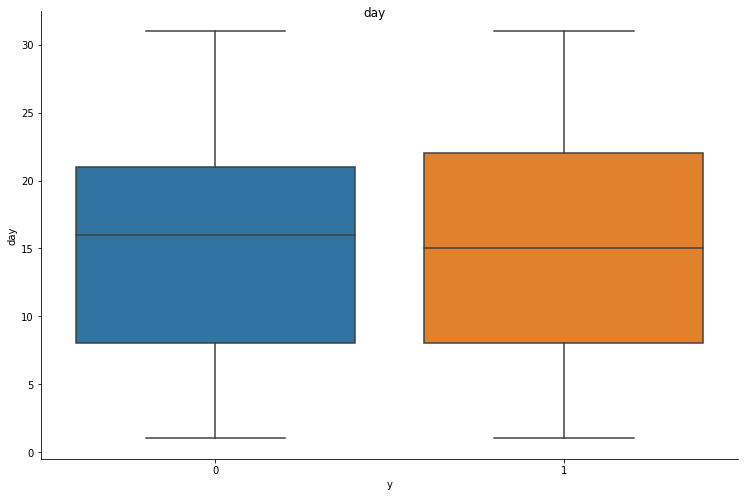

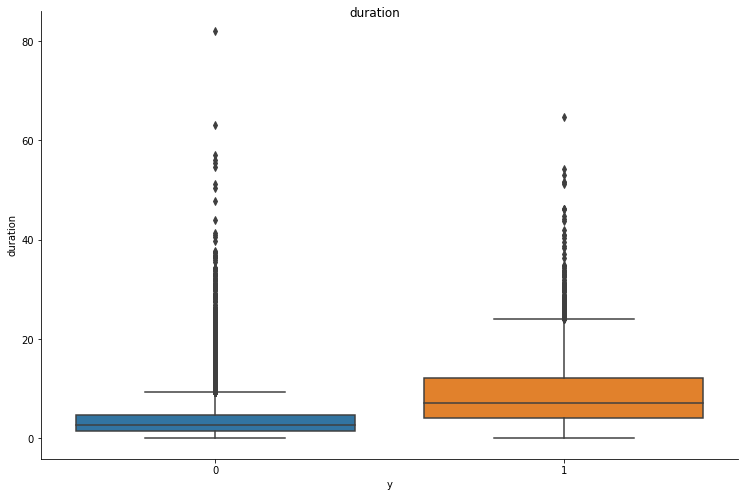

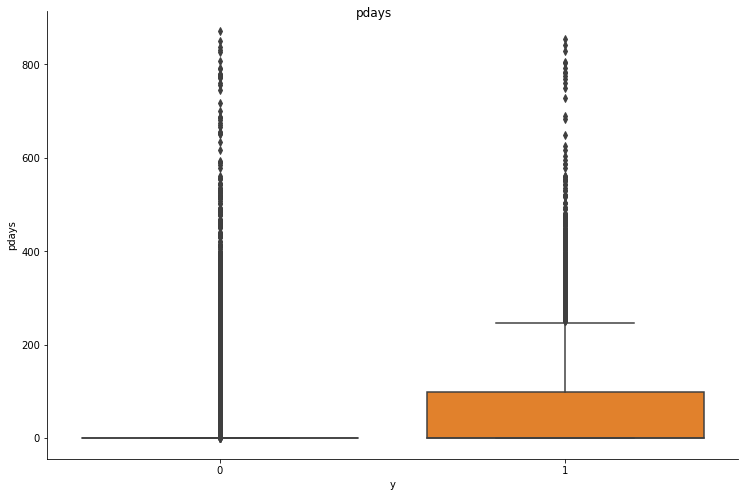

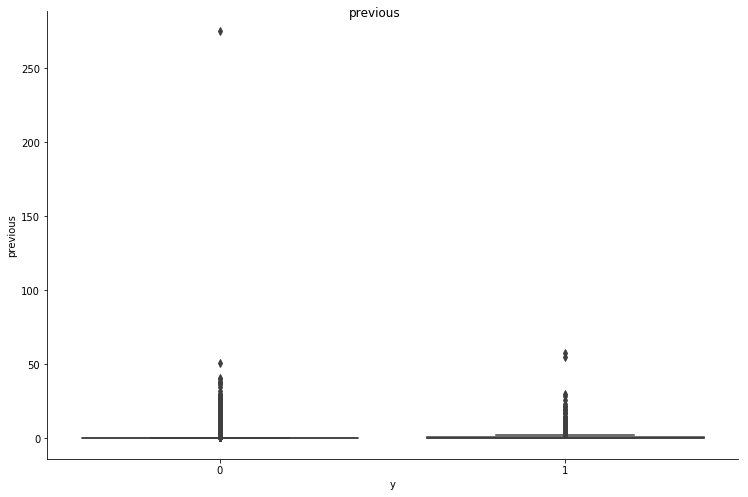

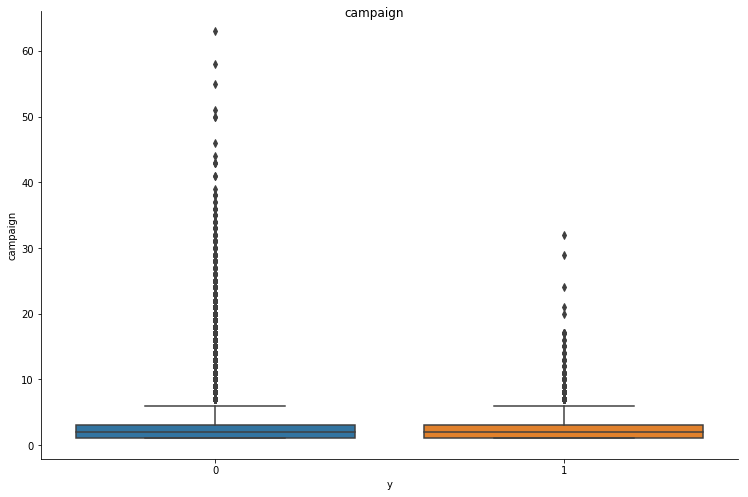

In [82]:
for i in continuous_feature_list:
    tt = sns.factorplot(kind='box',
                   x='y',
                   y=i,
                   data=df,
                   size=7,
                   aspect=1.5,
                   legend_out=False)
    tt.fig.suptitle(i)

<br>
Con estos diagramas de cajas podemos observar como todas las variables, excepto **duration** y **age** tienen aproximadamente la misma mediana y los mismos primer y tercer cuartiles para los valores 0 y 1 de la variable **y**.

En la variable **age** se puede ver como en la categoría 1 de **y** hay una mayor dispersión de edades que para la categoría 0 de **y**. No obstante, es muy posible que esta variable por sí sola no aporte mucha información a los modelos, pero en conjunto con otras variables sí.

Para la variable **duration**, se ve claramente que los clientes suscritos al depósito son los que han estado más minutos en contacto, por lo que es posible que sea una de las variables importantes para los modelos. Con la variable **pdays** parece que ocurre lo mismo, pero hay que tener en cuenta que el 81% de los registros tienen valor -1. Por lo tanto, lo que vemos en su diagrama de cajas es que hay una mayor proporción de valores -1 para la categoría 0 de **y**. Lo podemos ver a continuación:

In [83]:
df[['pdays', 'y']].groupby('y').describe()

pdays                                                   
     count       mean         std  min  25%  50%   75%    max
y                                                            
0  39922.0  36.421372   96.757135 -1.0 -1.0 -1.0  -1.0  871.0
1   5289.0  68.702968  118.822266 -1.0 -1.0 -1.0  98.0  854.0

<br>
Vemos que para la categoría 1, el tercer cuartil ya no es -1 y que la media es ligeramente más alta que para la categoría 0.

### Outliers

Los anteriores diagramas de cajas han mostrado muchos valores por encima de los bigotes superiores, los cuales se podrían clasificar como outliers. No obstante, en la mayoría de las variables esto puede deberse a que la proporción de registros sobre una misma serie de valores es muy alta, dejando los cuartiles con un valor bajo. En mi opinión, no todos los valores que sobrepasan los bigotes superiores son outliers debido a que pueden ser valores perfectamente posibles y no parecen errores de inserción. No obstante, he eliminado aquellos donde sí se ve una separación clara del resto de valores para las variables **previous**, **duration** y **balance**.

** *previous* **

In [84]:
print(len(df[df.previous > 50]), 'registros a eliminar')

4 registros a eliminar


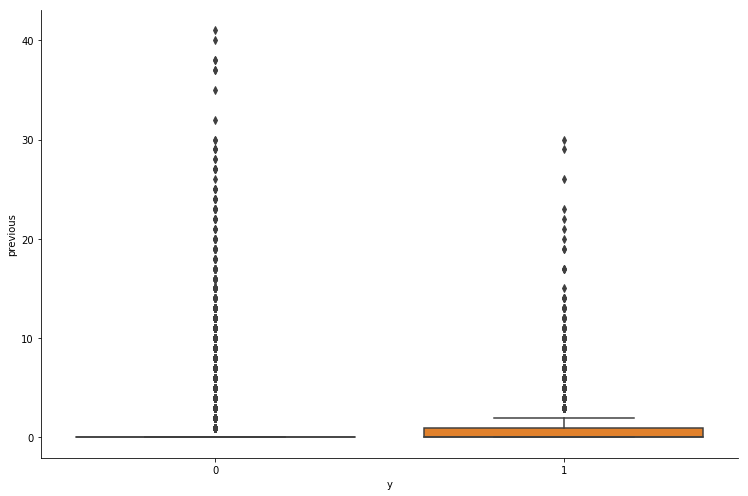

In [85]:
df = df[df.previous < 50]

sns.factorplot(kind='box',
               x='y',
               y='previous',
               data=df,
               size=7,
               aspect=1.5,
               legend_out=False)

** *duration* **

In [86]:
print(len(df[df.duration > 60]), 'registros a eliminar')

3 registros a eliminar


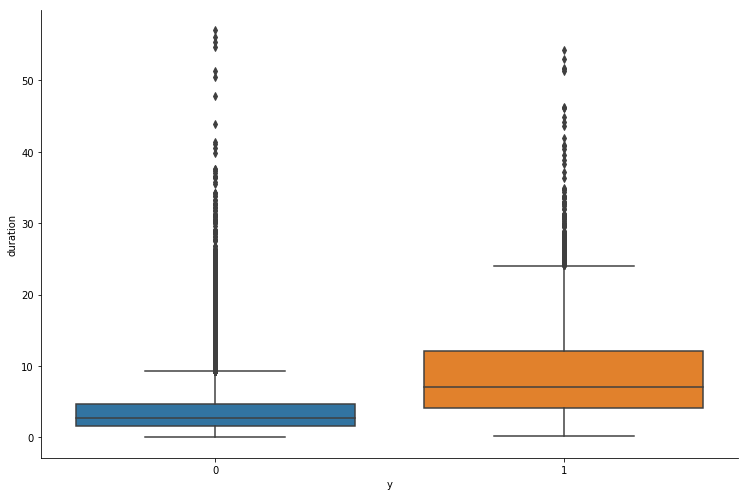

In [87]:
df = df[df.duration < 60]

sns.factorplot(kind='box',
               x='y',
               y='duration',
               data=df,
               size=7,
               aspect=1.5,
               legend_out=False)

** *balance* **

In [88]:
print(len(df[df.balance > 60000]), 'registros a eliminar')

8 registros a eliminar


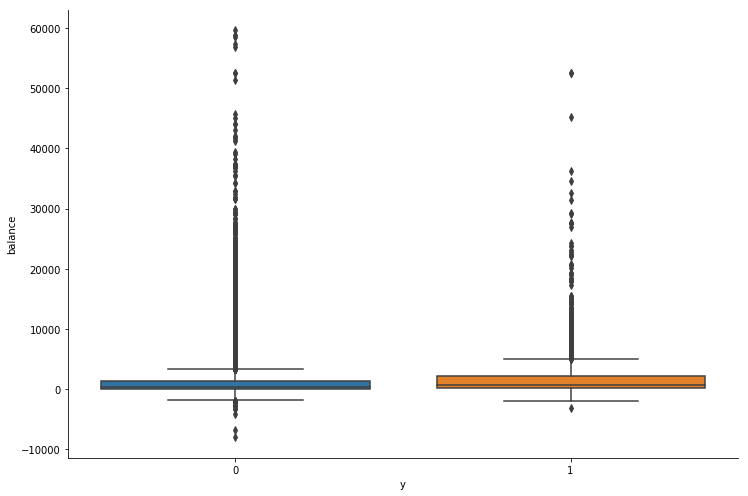

In [89]:
df = df[df.balance < 60000]

sns.factorplot(kind='box',
               x='y',
               y='balance',
               data=df,
               size=7,
               aspect=1.5,
               legend_out=False)

### Histogramas

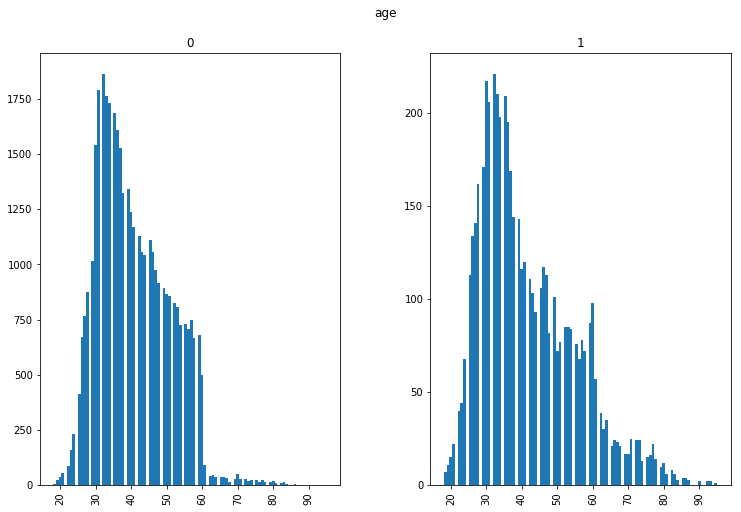

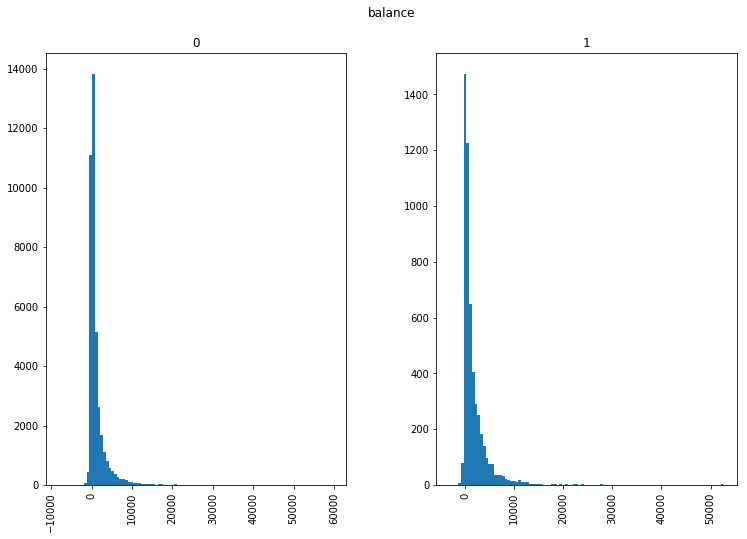

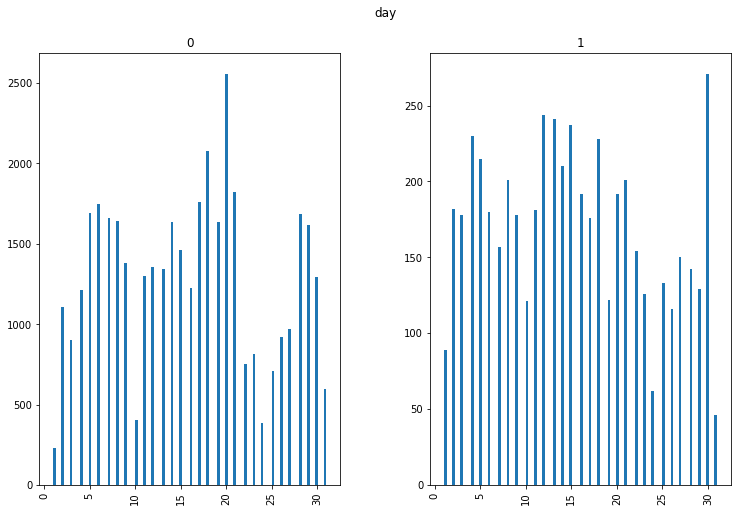

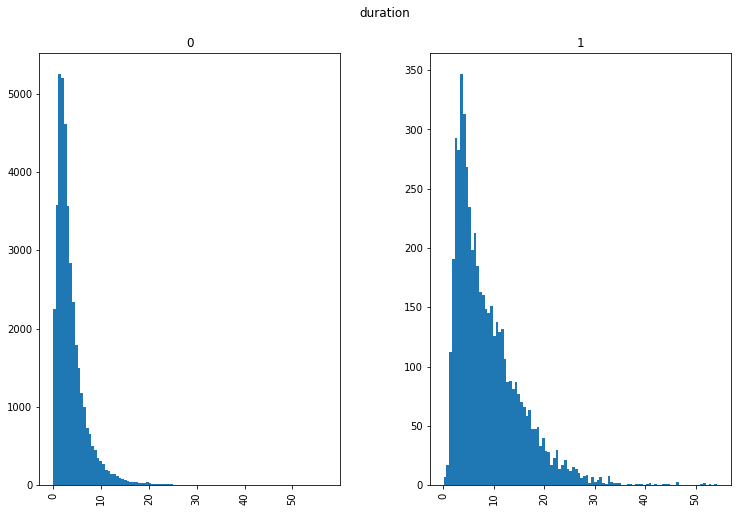

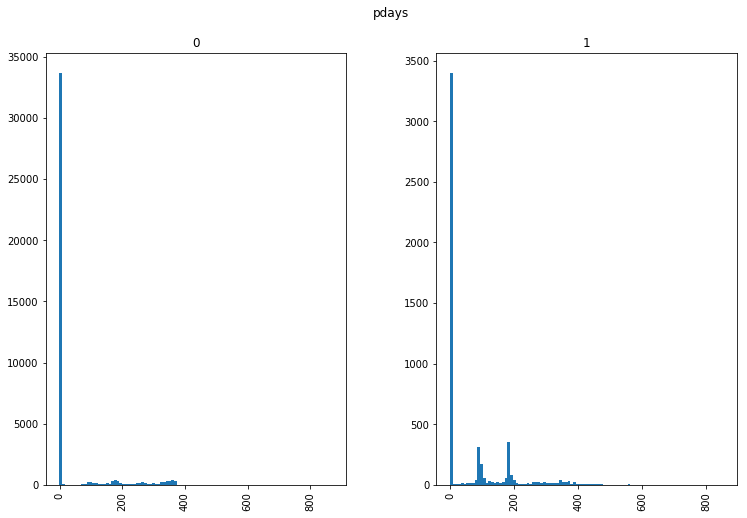

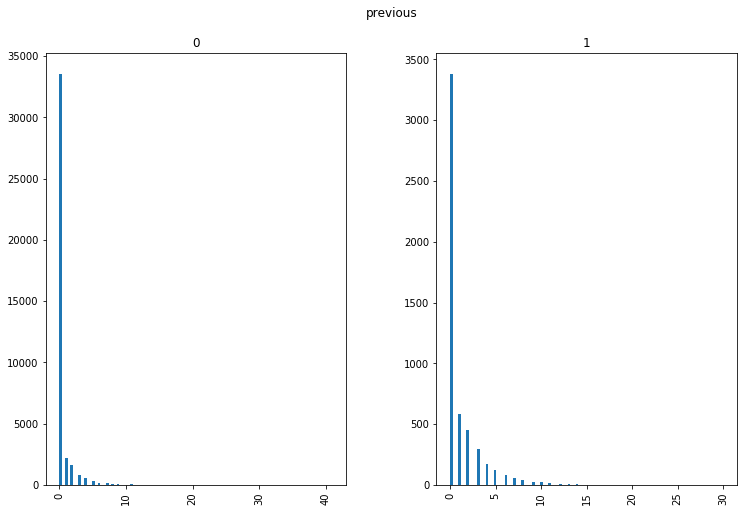

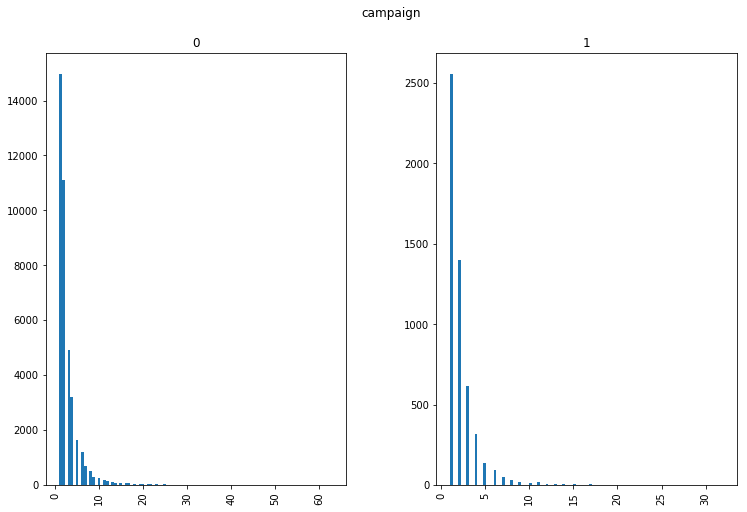

In [90]:
for i in continuous_feature_list:
    df.hist(column=i, by='y', bins=100)
    plt.suptitle(i)

### Diagramas de barras

A continuación, se discretizan las variables continuas para poder mostrar la proporción de suscritos y no suscritos al depósito por cada conjunto de valores. Se analiza la proporción debido a que no es posible comparar el efecto con el número de registros para cada categoría por haber una desproporción entre ambas (39.922 con valor 0 y 5289 con valor 1).

** *balance* **

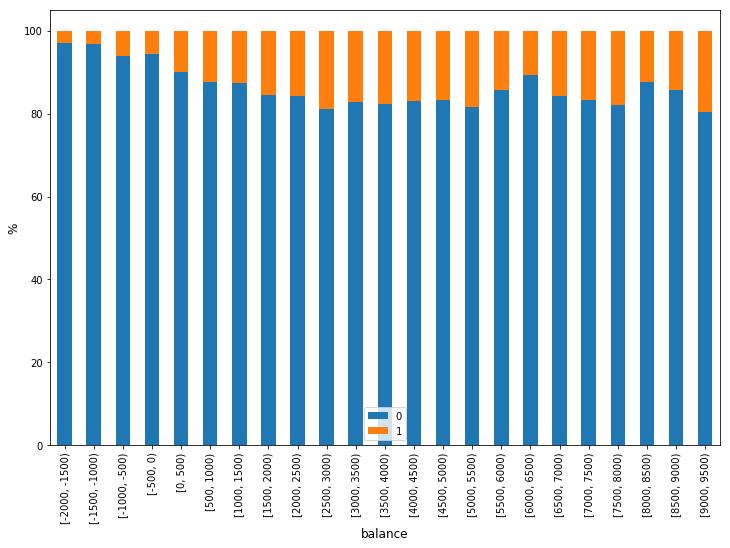

In [91]:
ranges =  [i for i in range(-2000, 10000, 500)]

temp = df[['balance', 'y']].groupby([pd.cut(df.balance, ranges, right=False), 'y']).count()
temp = temp.groupby(level=0).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', legend=True, stacked=True)
ax.set_xlabel("balance", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

** *duration* **

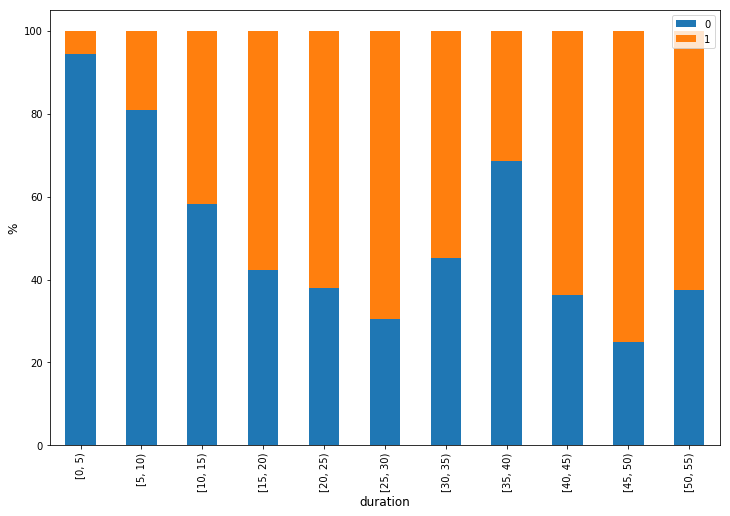

In [92]:
ranges =  [i for i in range(int(min(df.duration)), int(max(df.duration)), 5)]

temp = df[['duration', 'y']].groupby([pd.cut(df.duration, ranges, right=False), 'y']).count()
temp = temp.groupby(level=0).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', legend=True, stacked=True)
ax.set_xlabel("duration", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

** *pdays* **

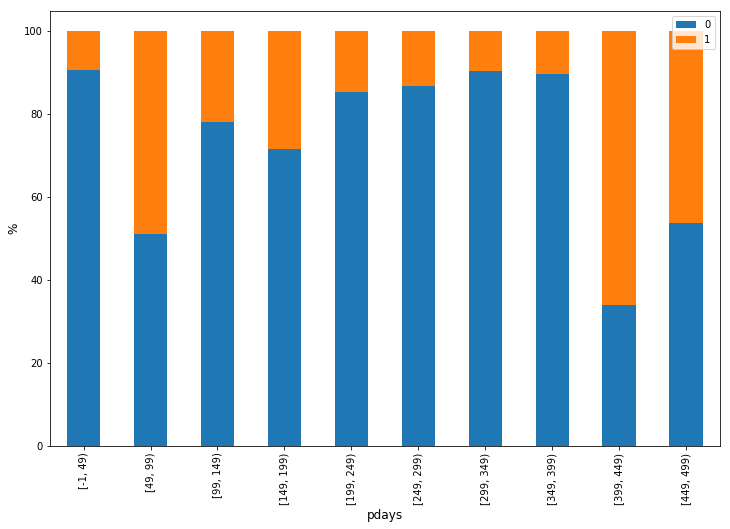

In [93]:
ranges =  [i for i in range(min(df.pdays), 500, 50)]

temp = df[['pdays', 'y']].groupby([pd.cut(df.pdays, ranges, right=False), 'y']).count()
temp = temp.groupby(level=0).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', legend=True, stacked=True)
ax.set_xlabel("pdays", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

** *previous* **

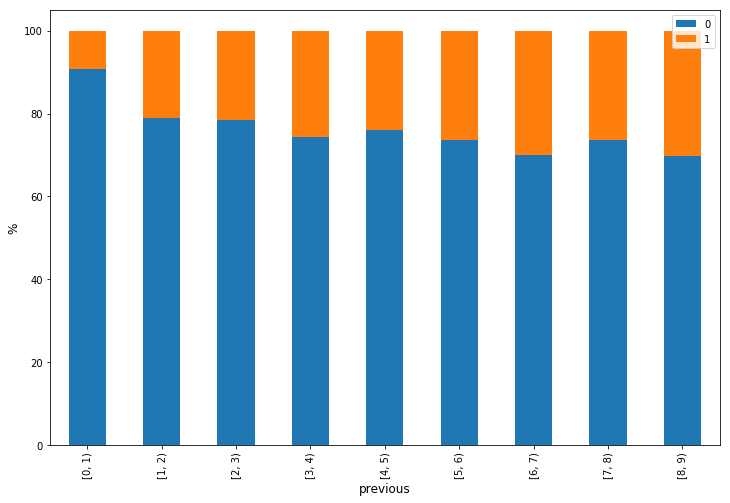

In [94]:
ranges =  [i for i in range(min(df.previous), 10, 1)]

temp = df[['previous', 'y']].groupby([pd.cut(df.previous, ranges, right=False), 'y']).count()
temp = temp.groupby(level=0).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', legend=True, stacked=True)
ax.set_xlabel("previous", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

** *campaign* **

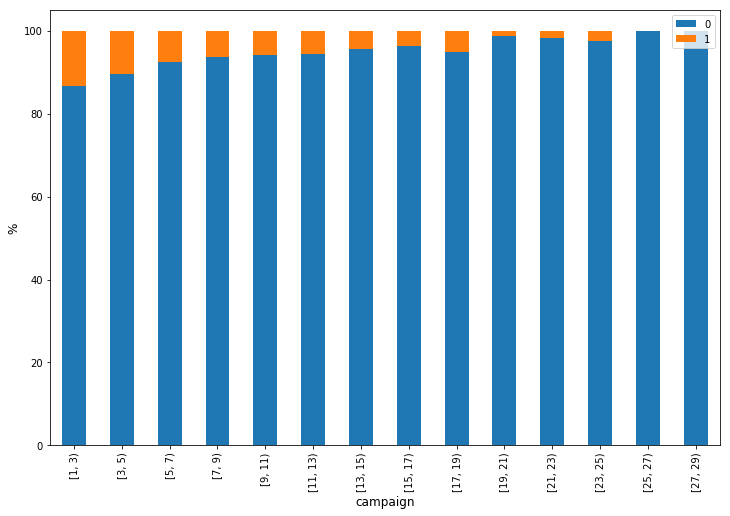

In [95]:
ranges =  [i for i in range(min(df.campaign), 30, 2)]

temp = df[['campaign', 'y']].groupby([pd.cut(df.campaign, ranges, right=False), 'y']).count()
temp = temp.groupby(level=0).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', legend=True, stacked=True)
ax.set_xlabel("campaign", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

## 2.2. Análisis de variables descriptivas <a class="anchor" id="analisis-descriptivas"></a>

Text(81.125,0.5,'Number of elements')

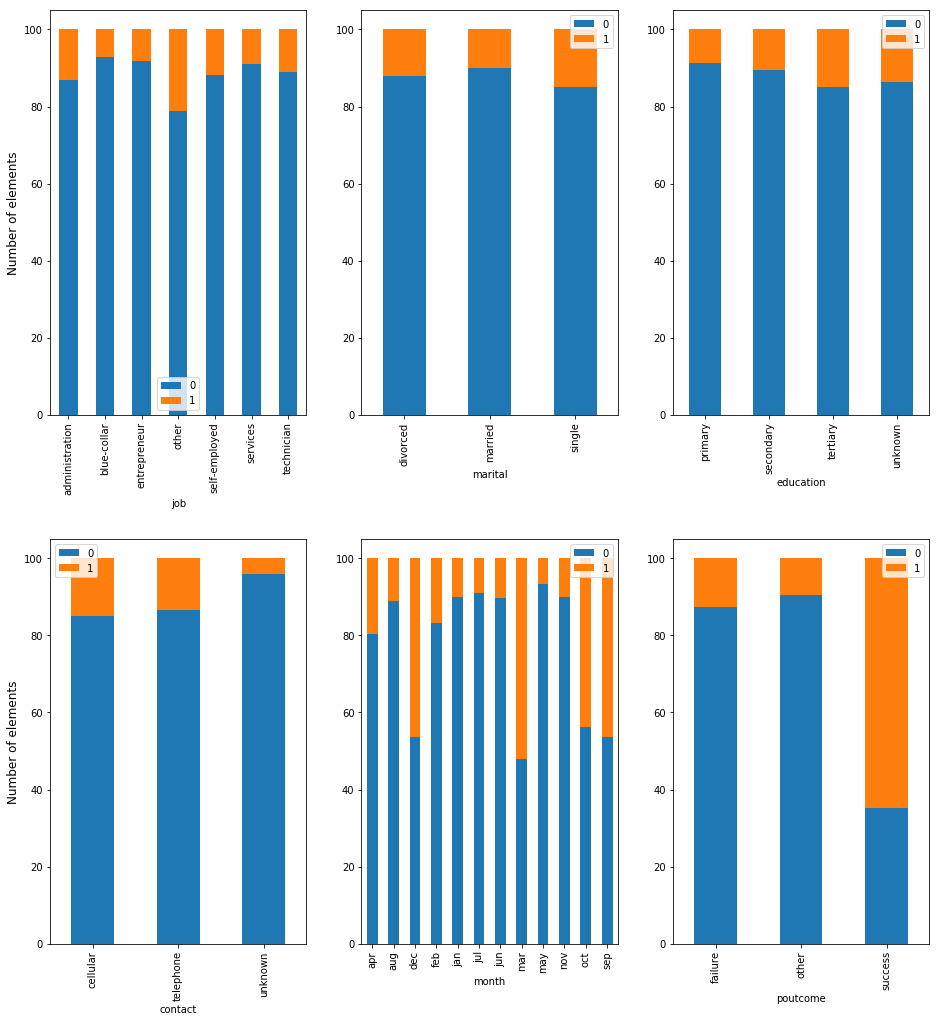

In [96]:
descriptive_features = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

fig, axis = plt.subplots(ncols=3, nrows=2)
plt.tight_layout(h_pad=5, w_pad=2)

for i, ax in enumerate(fig.axes):
    temp = df[[descriptive_features[i], 'y']].groupby([descriptive_features[i], 'y']).size()
    temp = temp.groupby(level=0).apply(lambda x: x * 100 / x.sum()).unstack()

    temp.plot(kind='bar', legend=True, ax=ax, figsize=(13, 14), stacked=True)
    ax.legend(["0", "1"])
    
axis[0][0].set_ylabel("Number of elements", fontsize=12)
axis[1][0].set_ylabel("Number of elements", fontsize=12)

## 2.3. Test Chi Square y Feature Importance <a class="anchor" id="feature-importance"></a>

Para la selección de variables, además, se puede utilizar el método $\chi^2$, el cual comprueba la independencia de dos eventos. En este caso se muestra la independencia entre las variables de entrenamiento y la variable objetivo. Se ha usado el *p-value* para medir el grado de independencia, siendo un *p-value* alto relación de gran independencia.

In [97]:
from sklearn.feature_selection import SelectKBest, chi2

<br>
Ha sido necesario crear variables **dummy** de las variables descriptivas.

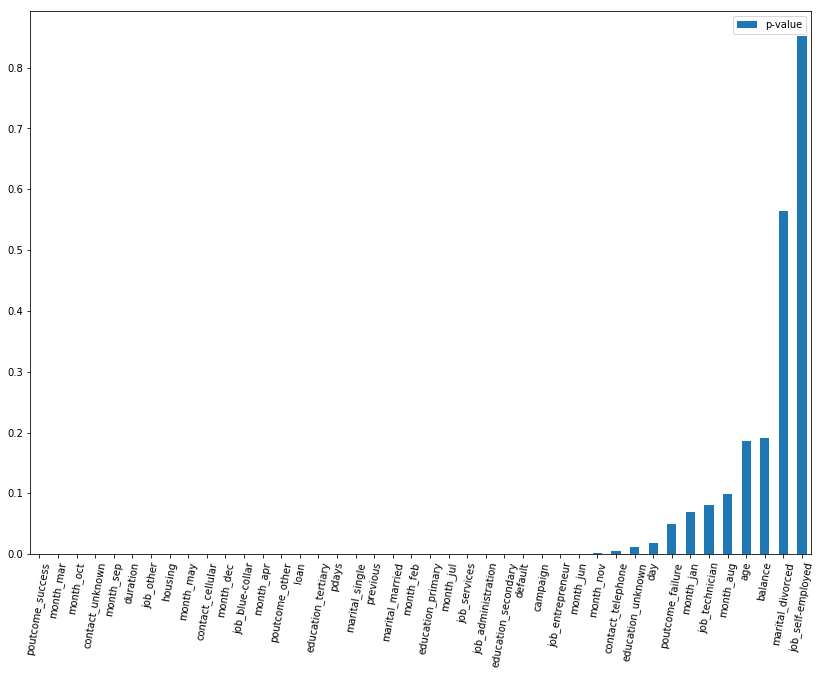

In [98]:
X = df.loc[:, df.columns != 'y']
Y = df.y

X_dummies = pd.get_dummies(X)
X_dummies_min_max = MinMaxScaler().fit_transform(X_dummies)

k_best_features = SelectKBest(chi2, k=10).fit(X_dummies_min_max, Y)

feat = pd.DataFrame(index=X_dummies.keys(), data=k_best_features.pvalues_, columns=['p-value'])
feat = feat.sort_values(by='p-value', ascending=True)

feat.plot(kind='bar', rot=80, figsize=(14, 10))

<br>
Las variables de **job**, **marital**, **balance** y **age** son las que más independencia muestran con respecto a la variable objetivo. Las variables de **poutcome** se muestran como las más dependientes de la variable objetivo.

<br>
Otro método para comprobar la importancia que tiene cada variable para la variable objetivo es entrenando, por ejemplo, un **Random Forest** y viendo qué variables ha considerado más importantes para realizar las separaciones. Este método es más robusto que el anterior, ya que tiene en cuenta a todas las variables en conjunto. Es decir, es posible que una variable por sí sola no tenga impacto sobre la variable objetivo, pero sobre otro espacio de dimensiones donde se tienen en cuenta a todas las variables, es posible que sí tenga impacto.

In [99]:
from sklearn.ensemble import RandomForestClassifier

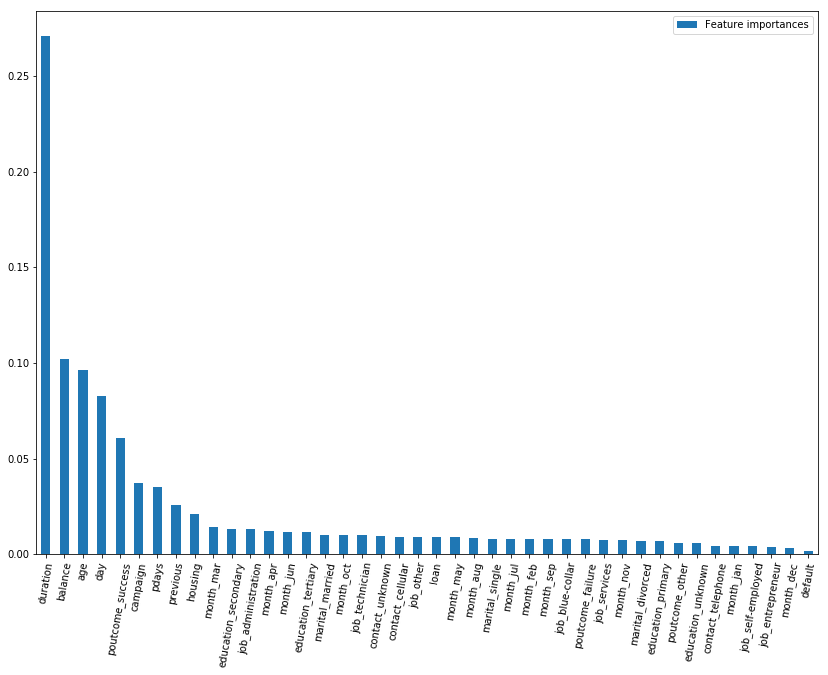

In [100]:
X = df.loc[:, df.columns != 'y']
Y = df.y

# Get dummies
X_dummies = pd.get_dummies(X)

# Scale between 0 to 1
X_dummies_min_max = MinMaxScaler().fit_transform(X_dummies)

# Random Forest Classifier
model = RandomForestClassifier()
model.fit(X_dummies_min_max, Y)

feat = pd.DataFrame(index=X_dummies.keys(), data=model.feature_importances_, columns=['Feature importances'])
feat = feat.sort_values(by='Feature importances', ascending=False)

feat.plot(kind='bar', rot=80, figsize=(14, 10))

<br>
En este caso, podemos observar como las variables **age** y **balance**, las cuales eran consideradas poco importantes con el anterior método, son las más importantes para los árboles aleatorios, junto a la variable **duration**. Además, las variables **poutcome**, como en el anterior método, también son importantes para el modelo.

En cambio, **job**, **marital** y **default** son las que se muestran menos importantes para los árboles aleatorios, siendo las dos primeras poco importantes también para el test $\chi^2$, por lo que se eliminarán y no se tendrán en cuenta en los modelos que se entrenen.

# 3. Selección del conjunto de datos final <a class="anchor" id="seleccion-datos"></a>

Como se ha comentado anteriormente, las variable **job**, **default**, **marital** y **contact** se eliminan del modelo de datos para no tenerlas en cuenta en el entrenamiento de los modelos.

In [101]:
df_final = df[df.columns.difference(['job', 'marital', 'default', 'contact'])]

<br>
A continuación, se crean las variables **dummies** de las variables descriptivas.

In [102]:
df_dummies = pd.get_dummies(df_final)
df_dummies.shape

(45196, 29)

In [103]:
df_dummies.head()

,age,balance,campaign,day,duration,housing,loan,pdays,previous,y,education_primary,education_secondary,education_tertiary,education_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success
0,58,2143,1,5,4.350000,1,0,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,44,29,1,5,2.516667,1,0,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,33,2,1,5,1.266667,1,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,47,1506,1,5,1.533333,1,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,33,1,1,5,3.300000,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


## 3.1. Balanceamiento de clases <a class="anchor" id="balance"></a>

In [128]:
from sklearn.utils import resample

In [129]:
df_majority = df_dummies[df_dummies.y == 0]
df_minority = df_dummies[df_dummies.y == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace = True,
                                 n_samples = round(len(df_majority) / 2),
                                 random_state = 123)

df_upsampled = pd.concat([df_minority_upsampled, df_majority])

<br>
Hemos pasado de 45.196 registros, a 59.868:

In [130]:
len(df_upsampled)

59868

<br>
La clase minoritaria tenía 5.284 registros, y ahora tiene 19.956:

In [131]:
len(df_minority_upsampled)

19956

<br>
Por lo que la clase minoritaria ahora representa un 33% de los registros:

In [132]:
 len(df_minority_upsampled) / len(df_upsampled)

0.3333333333333333

# 4. Separación de datos de entrenamiento y prueba <a class="anchor" id="train-test"></a>

In [133]:
from sklearn.model_selection import train_test_split

<br>
Separamos los datos en entrenamiento y prueba (30%) del conjunto de datos completo.

In [134]:
df_X = df_upsampled.loc[:, df_upsampled.columns != 'y']
df_y = df_upsampled.y

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y,
                                                    test_size = 0.3, 
                                                    random_state = 1234)

In [135]:
print("X_train: " + str(X_train.shape))
print("X_test:  " + str(X_test.shape))
print("y_train: " + str(y_train.shape))
print("y_test:  " + str(y_test.shape))

X_train: (41907, 28)
X_test:  (17961, 28)
y_train: (41907,)
y_test:  (17961,)


# 5. K-Nearest Neighbors Classifier <a class="anchor" id="knn"></a>

A continuación, realizamos un *GridSearchCV* de un **K-Nearest Neighbors** con $k-vecinos = [12, 20]$, considerando pesos uniformes o la inversa de su distancia, y midiendo con la distancia de Manhattan y la Euclidiana.

In [99]:
from sklearn.neighbors import KNeighborsClassifier

In [100]:
scaler = MinMaxScaler()
knn_class = KNeighborsClassifier()

scaler_step = ('scaler', scaler)
knn_class_step = ('knn', knn_class)
steps = [scaler_step, knn_class_step]
pipe = Pipeline(steps)

params = {'knn__n_neighbors': range(12, 20),
          'knn__weights': ['uniform', 'distance'],
          'knn__p': [1, 2]} # p = 1 -> manhattan_distance (L1), p = 2 -> euclidean_distance (L2)

kfold = StratifiedKFold(n_splits = 10)

gs_knn_class = GridSearchCV(pipe, param_grid=params, cv=kfold, n_jobs=5)
gs_knn_class.fit(X_train, y_train)

y_pred_gs_knn_class = gs_knn_class.predict(X_test)
y_pred_gs_knn_class_proba = gs_knn_class.predict_proba(X_test)

print("Best params: ", gs_knn_class.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_gs_knn_class_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_gs_knn_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_gs_knn_class))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_gs_knn_class))

Best params:  {'knn__n_neighbors': 14, 'knn__p': 1, 'knn__weights': 'uniform'}


ROC Curve: 0.87


Confusion matrix: 
 [[  381  1262]
 [  204 11712]]


Accuracy: 0.891879932148


Classification report: 
              precision    recall  f1-score   support

          0       0.90      0.98      0.94     11916
          1       0.65      0.23      0.34      1643

avg / total       0.87      0.89      0.87     13559



# 6. Regresión logística <a class="anchor" id="regresion-logistica"></a>

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
scaler = MinMaxScaler()
class_LR = LogisticRegression()

scaler_step = ('scaler', scaler)
class_LR_step = ('class_LR', class_LR)
steps = [scaler_step, class_LR_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)

y_pred_LR = pipe.predict(X_test)
y_pred_LR_proba = pipe.predict_proba(X_test)

print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_LR_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_LR, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_LR))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_LR))

ROC Curve: 0.90


Confusion matrix: 
 [[  541  1102]
 [  286 11630]]


Accuracy: 0.897632568774


Classification report: 
              precision    recall  f1-score   support

          0       0.91      0.98      0.94     11916
          1       0.65      0.33      0.44      1643

avg / total       0.88      0.90      0.88     13559



# 7. Árbol de decisión <a class="anchor" id="arbol-decision"></a>

Los árboles de decisión son algoritmos de aprendizaje supervisado donde es posible visualizar el árbol de decisión entrenado, por lo que la interpretación de los resultados es más fácil. La forma en la que se genera un árbol de decisión es cogiendo el mejor atributo del conjunto de datos y situándolo en la *raíz* del árbol, para hacer un *split* y obtener un subconjunto de datos más pequeño. Posteriormente, se realizan estos mismos pasos en cada subconjunto de datos hasta encontrar los *nodos hoja* en cada una de las ramas del árbol. Los árboles de decisión, aunque son fácilmente interpretables, sufren por tener una alta varianza y un pequeño cambio en los datos, puede cambiar el resultado final del árbol. 

In [58]:
from sklearn.tree import DecisionTreeClassifier

## 7.1 Árbol de decisión básico <a class="anchor" id="arbol-decision-basico"></a>

Creamos un modelo con un árbol de decisión sin modificar ningún parámetro:

In [59]:
scaler = MinMaxScaler()
class_DT = DecisionTreeClassifier()

scaler_step = ('scaler', scaler)
class_DT_step = ('class_DT', class_DT)
steps = [scaler_step, class_DT_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)

y_pred_class_DT = pipe.predict(X_test)
y_pred_class_DT_proba = pipe.predict_proba(X_test)

print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_class_DT_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_class_DT, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_class_DT))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_class_DT))

ROC Curve: 0.70


Confusion matrix: 
 [[  795   848]
 [  896 11020]]


Accuracy: 0.871376945202


Classification report: 
              precision    recall  f1-score   support

          0       0.93      0.92      0.93     11916
          1       0.47      0.48      0.48      1643

avg / total       0.87      0.87      0.87     13559



## 7.2 Árbol de decisión mediante GridSearchCV <a class="anchor" id="arbol-decision-gs"></a>

Para ver si mejora un modelo basado en árboles de decisión, utilizamos la función de **GridSearchCV** para modificar los parámetros.

In [70]:
scaler = MinMaxScaler()
class_DT = DecisionTreeClassifier()

scaler_step = ('scaler', scaler)
class_DT_step = ('class_DT', class_DT)
steps = [scaler_step, class_DT_step]
pipe = Pipeline(steps)

params = {'class_DT__max_depth': range(2, 15),
          'class_DT__min_samples_split': range(2, 15),
          'class_DT__min_samples_leaf': range(2, 15),
          'class_DT__criterion': ['gini', 'entropy']}

kfold = StratifiedKFold(n_splits = 10)

gs_class_DT = GridSearchCV(pipe, param_grid=params, cv=kfold, n_jobs=-1)
gs_class_DT.fit(X_train, y_train)

y_pred_gs_class_DT = gs_class_DT.predict(X_test)
y_pred_gs_class_DT_proba = gs_class_DT.predict_proba(X_test)

print("Best params: ", gs_class_DT.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_gs_class_DT_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_gs_class_DT, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_gs_class_DT))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_gs_class_DT))

Best params:  {'class_DT__criterion': 'entropy', 'class_DT__min_samples_leaf': 2, 'class_DT__max_depth': 7, 'class_DT__min_samples_split': 2}


ROC Curve: 0.88


Confusion matrix: 
 [[  610  1033]
 [  387 11529]]


Accuracy: 0.895272512722


Classification report: 
              precision    recall  f1-score   support

          0       0.92      0.97      0.94     11916
          1       0.61      0.37      0.46      1643

avg / total       0.88      0.90      0.88     13559



Observamos que la métrica ROC Curve ha pasado de un 0.70 a un 0.88, usando una profundidad de 7, lo que podría decir que usa pocas variables para crear el árbol. Por este motivo, vamos a estudiar a continuación qué variables son las más importantes para el árbol generado.

## 7.3 Visualización de las variables más importantes <a class="anchor" id="arbol-decision-visualizacion"></a>

A partir de los mejores parámetros para el árbol encontrados en el anterior *GridSearchCV*, generamos el árbol.

In [71]:
scaler = MinMaxScaler()
class_DT = DecisionTreeClassifier(max_depth = gs_class_DT.best_params_['class_DT__max_depth'],
                                  min_samples_leaf = gs_class_DT.best_params_['class_DT__min_samples_leaf'],
                                  min_samples_split = gs_class_DT.best_params_['class_DT__min_samples_split'],
                                  criterion = gs_class_DT.best_params_['class_DT__criterion'])

scaler_step = ('scaler', scaler)
class_DT_step = ('class_DT', class_DT)
steps = [scaler_step, class_DT_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('class_DT', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

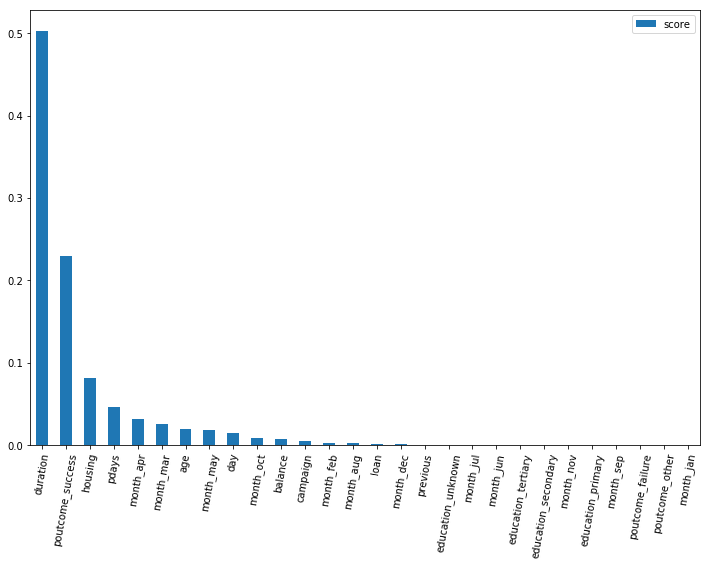

In [72]:
feat = pd.DataFrame(index=X_train.keys(), data=class_DT.feature_importances_, columns=['score'])
feat = feat.sort_values(by='score', ascending=False)

feat.plot(kind='bar', rot=80)

Las cuatro variables más importantes que ha considerado el algoritmo son **duration**, **poutcome_succes**, **housing** y **pdays**.

# 8. Random Forest <a class="anchor" id="random-forest"></a>

In [7]:
from sklearn.ensemble import RandomForestClassifier

**Random Forest** provee una mejora sobre los árboles de decisión para reducir la varianza. Esto se hace de modo que cada vez que se hace una división en un árbol, se considera una selección aleatoria de m predictores elegidos como candidatos de división de todo el conjunto de p predictores.

Normalmente se usan $m = \sqrt{p} \quad$  o  $\quad m = p$, y se pueden indicar en el siguiente algoritmo mediante el parámetro **max_features = 'sqrt'** o **max_features = 'auto'**, respectivamente. Además, con el parámetro **n_estimators** indicamos el número de árboles que se generan y con **max_depth** la profundidad de cada árbol. Estimamos la mejor combinación de estos parámetros mediante *GridSearchCV*.

In [74]:
scaler = MinMaxScaler()
rand_for_class = RandomForestClassifier()

scaler_step = ('scaler', scaler)
rand_for_class_step = ('rand_for_class', rand_for_class)
steps = [scaler_step, rand_for_class_step]
pipe = Pipeline(steps)

tuned_parameters = {'rand_for_class__n_estimators': range(35, 48, 2),
                    'rand_for_class__max_features': ['sqrt', 'auto'],
                    'rand_for_class__max_depth': range(12, 22)}

kfold = StratifiedKFold(n_splits = 10)

gs_rand_for_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_rand_for_class.fit(X_train, y_train)

y_pred_rand_for_class = gs_rand_for_class.predict(X_test)
y_pred_rand_for_class_proba = gs_rand_for_class.predict_proba(X_test)

print("Best params: ", gs_rand_for_class.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_rand_for_class_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_rand_for_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_rand_for_class))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_rand_for_class))

Best params:  {'rand_for_class__max_depth': 17, 'rand_for_class__max_features': 'auto', 'rand_for_class__n_estimators': 41}


ROC Curve: 0.93


Confusion matrix: 
 [[  624  1019]
 [  322 11594]]


Accuracy: 0.901098901099


Classification report: 
              precision    recall  f1-score   support

          0       0.92      0.97      0.95     11916
          1       0.66      0.38      0.48      1643

avg / total       0.89      0.90      0.89     13559



## 8.1 Visualización de las variables más importantes <a class="anchor" id="random-forest-visualizacion"></a>

A continuación, comprobamos cuáles son las variables que ha encontrado más importantes para generar los árboles aleatorios.

In [75]:
scaler = MinMaxScaler()
rand_for_class = RandomForestClassifier(
                    n_estimators = gs_rand_for_class.best_params_['rand_for_class__n_estimators'],
                    max_features = gs_rand_for_class.best_params_['rand_for_class__max_features'],
                    max_depth = gs_rand_for_class.best_params_['rand_for_class__max_depth'])

scaler_step = ('scaler', scaler)
rand_for_class_step = ('rand_for_class', rand_for_class)
steps = [scaler_step, rand_for_class_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('rand_for_class', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
       ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

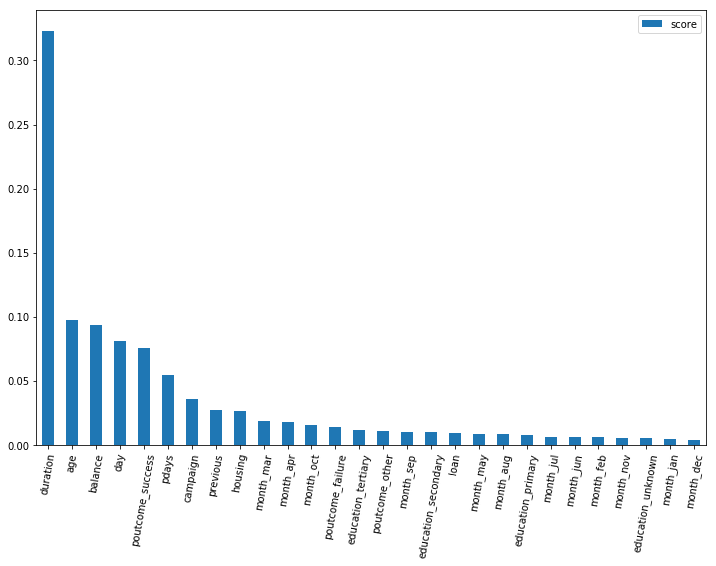

In [76]:
feat = pd.DataFrame(index=X_train.keys(), data=rand_for_class.feature_importances_, columns=['score'])
feat = feat.sort_values(by='score', ascending=False)

feat.plot(kind='bar', rot=80)

<br>
Observamos que los modelos de **Regresión Logística**, **Árbol de decisión** y **Random Forest** nos dan resultados parecidos, siendo este último el mejor de los tres. No obstante, como ya hemos dicho, **Random Forest** provee una mejora sobre los árboles de decisión para reducir la varianza.

# 9. SVM <a class="anchor" id="svm"></a>

In [53]:
from sklearn.svm import SVC

A continuación, se prueban tres modelos de SVM con tres kernels diferentes: **lineal**, **Radial Basis Function (*RBF*)** y **polinomial** de grado 3. Los parámetros para los tres modelos son los mismos, exceptuando el parámetros **gamma** para el RBF y el parámetro **degree** para el polinomial.

Los parámetros a analizar mediante *GridSearchCV* son:

* **C**: parámetro de penalización del término de error. Cuanto mayor sea el valor de C, menor número de errores se permitiràn, por lo que si $C -> \infty$ se consideraría que todos los ejemplos son perfectamente separables. Cuanto más pequeño sea C, mayor número de errores se admitirían de ejemplos mal clasificados.

Los parámetros que se espefican de manera fija son:

* **tol**: Tolerancia máxima aceptada para converger.
* **max_iter**: número máximo de iteraciones que se realizarían en caso de no haber convergido con la tolerancia especificada.

La formulación matemática para las SVM de clasificación es la siguiente. Dados los vectores de entrenamiento $x_i \in \mathbb{R}^p, i = 1, ..., n$, en dos clases, y un vector $y \in \{1, -1\}^n$, se resuelve el siguiente problema primal:

$$ min_{\omega, b, \zeta} \frac{1}{2} \omega^T \omega + C \sum_{i=1}^n \zeta_i$$

sujeto a

$$ y_i (\omega^T \phi(x_i) + b) \le 1 - \zeta_i $$
$$ \zeta_i \ge 0, i = 1, ..., n $$

## 9.1. SVM con Kernel lineal <a class="anchor" id="svm-lineal"></a>

La función del kernel lineal es $\langle x, x' \rangle$.

In [55]:
scaler = MinMaxScaler()
svc_lin_class = SVC(kernel='linear', 
                    shrinking=True, 
                    cache_size=4096, 
                    max_iter=10000000, 
                    tol=10e-3)

scaler_step = ('scaler', scaler)
svc_lin_class_step = ('svc_lin_class', svc_lin_class)
steps = [scaler_step, svc_lin_class_step]
pipe = Pipeline(steps)

c = [0.001, 0.01, 0.1, 1, 5, 10, 100]

tuned_parameters = {'svc_lin_class__C': c}

kfold = StratifiedKFold(n_splits = 10)

gs_svc_lin_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_svc_lin_class.fit(X_train, y_train)

y_pred_svc_lin_class = gs_svc_lin_class.predict(X_test)

print("Best params: ", gs_svc_lin_class.best_params_)
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_svc_lin_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_svc_lin_class))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_svc_lin_class))

Best params:  {'svc_lin_class__C': 0.01}


Confusion matrix: 
 [[  296  1347]
 [  157 11759]]


Accuracy: 0.8890773655874327


Classification report: 
              precision    recall  f1-score   support

          0       0.90      0.99      0.94     11916
          1       0.65      0.18      0.28      1643

avg / total       0.87      0.89      0.86     13559



## 9.2. SVM con Kernel RBF <a class="anchor" id="svm-rbf"></a>

Cuando se entrena una SVM con el kernel **RBF**, se han de tener en cuenta los parámetros *C* y *gamma*, entre los que existe un *trade-off*. El parámetro *gamma* define cuánta influencia tiene un único ejemplo del entrenamiento. Cuando más grande sea *gamma*, más cercanos han de estar otros ejemplos para ser afectados.

Si *gamma* es muy grande, el radio del área de influencia de los vectores de soporte solo incluye al propio soporte y *C* no tendrá ningún tipo de influencia. Por el contrario, cuando *gamma* es muy pequeño, el modelo queda muy limitado y no es capaz de ver toda la complejidad de los datos en el espacio de dimensiones. Cualquier vector de soporte incluirá todo el dataset de entrenamiento.

En la siguiente gráfica se puede observar dicho *trade-off*:

![Validation accuracy](http://scikit-learn.org/stable/_images/sphx_glr_plot_rbf_parameters_002.png)

Por este motivo, para el *GridSearchCV* se han escogido unos valores de *gamma* de {0.001, 0.01, 0.1, 1, 10}, dado que la *C* podrá tener los valores {0.001, 0.01, 0.1, 1, 5, 10, 100}.

La función del kernel radial es $exp(-\gamma \| x - x'\|^2)$, donde $\gamma$ es el parámetro *gamma*.

In [56]:
scaler = MinMaxScaler()
svc_rbf_class = SVC(kernel='rbf', 
                    shrinking=True, 
                    cache_size=4096, 
                    max_iter=10000000, 
                    tol=10e-3)

scaler_step = ('scaler', scaler)
svc_rbf_class_step = ('svc_rbf_class', svc_rbf_class)
steps = [scaler_step, svc_rbf_class_step]
pipe = Pipeline(steps)

c = [0.001, 0.01, 0.1, 1, 5, 10, 100]
gamma = [0.001, 0.01, 0.1, 1, 10]

tuned_parameters = {'svc_rbf_class__C': c, 
                    'svc_rbf_class__gamma': gamma}

kfold = StratifiedKFold(n_splits = 10)

gs_svc_rbf_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_svc_rbf_class.fit(X_train, y_train)

y_pred_svc_rbf_class = gs_svc_rbf_class.predict(X_test)

print("Best params: ", gs_svc_rbf_class.best_params_)
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_svc_rbf_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_svc_rbf_class))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_svc_rbf_class))

Best params:  {'svc_rbf_class__C': 100, 'svc_rbf_class__gamma': 0.1}


Confusion matrix: 
 [[  514  1129]
 [  252 11664]]


Accuracy: 0.8981488310347371


Classification report: 
              precision    recall  f1-score   support

          0       0.91      0.98      0.94     11916
          1       0.67      0.31      0.43      1643

avg / total       0.88      0.90      0.88     13559



## 9.3. SVM con Kernel polinomial <a class="anchor" id="svm-poly"></a>

La función del kernel polinolial es $(\gamma \langle x, x' \rangle + r)^d$, donde $d$ es el parámetro *degree*, $r$ el parámetro *coef0* (por defecto es 0) y $\gamma$ es el parámetro *gamma*.

In [57]:
scaler = MinMaxScaler()
svc_ps_class = SVC(kernel='poly',
                   shrinking=True, 
                   cache_size=4096, 
                   max_iter=10000000,
                   tol=10e-2, 
                   degree=3)

scaler_step = ('scaler', scaler)
svc_ps_class_step = ('svc_ps_class', svc_ps_class)
steps = [scaler_step, svc_ps_class_step]
pipe = Pipeline(steps)

c = [0.001, 0.01, 0.1, 1, 5, 10, 100]
gamma = [0.001, 0.01, 0.1, 1, 10]

tuned_parameters = {'svc_ps_class__C': c, 
                    'svc_ps_class__gamma': gamma}

kfold = StratifiedKFold(n_splits = 10)

gs_svc_ps_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_svc_ps_class.fit(X_train, y_train)

y_pred_svc_ps_class = gs_svc_ps_class.predict(X_test)

print("Best params: ", gs_svc_ps_class.best_params_)
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_svc_ps_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_svc_ps_class))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_svc_ps_class))

Best params:  {'svc_ps_class__gamma': 10, 'svc_ps_class__C': 0.001}


Confusion matrix: 
 [[  539  1104]
 [  279 11637]]


Accuracy: 0.8980013275315288


Classification report: 
              precision    recall  f1-score   support

          0       0.91      0.98      0.94     11916
          1       0.66      0.33      0.44      1643

avg / total       0.88      0.90      0.88     13559



## 9.4. Conclusiones de SVM <a class="anchor" id="svm-result"></a>

Los resultados finales de los modelos de SVM anteriores han sido:

In [4]:
svm_models = ['SVM con kernel lineal', 'SVM con kernel RBF', 'SVM con kernel polinomial']
C = [0.01, 100, 0.001]
gamma = ['-', 0.1, 10]
accuracy = [0.8890773655874327, 0.8981488310347371, 0.8980013275315288]
precision = [0.65, 0.67, 0.66]
recall = [0.18, 0.31, 0.33]
f1 = [0.28, 0.43, 0.44]

df_svm_models = pd.concat([pd.Series(svm_models), pd.Series(C), pd.Series(gamma),
                          pd.Series(accuracy), pd.Series(precision), 
                          pd.Series(recall), pd.Series(f1)], axis=1)
df_svm_models.columns = ['SVM Model', 'C', 'gamma', 'Accuracy', 'Precision', 'Recall', 'F1']
df_svm_models

,SVM Model,C,gamma,Accuracy,Precision,Recall,F1
0,SVM con kernel lineal,0.010,-,0.889077,0.65,0.18,0.28
1,SVM con kernel RBF,100.000,0.1,0.898149,0.67,0.31,0.43
2,SVM con kernel polinomial,0.001,10,0.898001,0.66,0.33,0.44


<br>
sdf

# 10. Redes neuronales <a class="anchor" id="neural-net"></a>

In [83]:
from sklearn.neural_network import MLPClassifier

Generamos varias combinaciones de número de neuronas en una, dos y tres capas.

In [84]:
import itertools

n_neurons = [1, 3, 5, 10]
hidden_layer_sizes = n_neurons

for two_layer in itertools.product(n_neurons, repeat=2):
    hidden_layer_sizes.append(two_layer)

n_neurons = [1, 3, 5]
for three_layer in itertools.product(n_neurons, repeat=3):
    hidden_layer_sizes.append(three_layer)
    
hidden_layer_sizes

[1,
 3,
 5,
 10,
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 10),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 10),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 10),
 (10, 1),
 (10, 3),
 (10, 5),
 (10, 10),
 (1, 1, 1),
 (1, 1, 3),
 (1, 1, 5),
 (1, 3, 1),
 (1, 3, 3),
 (1, 3, 5),
 (1, 5, 1),
 (1, 5, 3),
 (1, 5, 5),
 (3, 1, 1),
 (3, 1, 3),
 (3, 1, 5),
 (3, 3, 1),
 (3, 3, 3),
 (3, 3, 5),
 (3, 5, 1),
 (3, 5, 3),
 (3, 5, 5),
 (5, 1, 1),
 (5, 1, 3),
 (5, 1, 5),
 (5, 3, 1),
 (5, 3, 3),
 (5, 3, 5),
 (5, 5, 1),
 (5, 5, 3),
 (5, 5, 5)]

A continuación, se realiza un *GridSearchCV* para todas estas posibilidades de redes neuronales, con funciones de activación **logistic** y **relu**, para un *alpha* (Penalizació L2) de {0.00001, 0.0001, 0.001} y un *learning rate* constante de {0.0001, 0.001, 0.01}.

La función de optimización usada es **adam**, la cual hace referencia al optimizador de descendiente del gradiente estocástico propuesto por Kingma, Diederik y Jimmy Ba.

In [85]:
scaler = MinMaxScaler()
mlp_class = MLPClassifier(solver='adam',
                          max_iter=1000)

scaler_step = ('scaler', scaler)
mlp_class_step = ('mlp_class', mlp_class)
steps = [scaler_step, mlp_class_step]
pipe = Pipeline(steps)

activation = ['logistic', 'relu']
alpha = [0.00001, 0.0001, 0.001]
learning_rate_init = [0.0001, 0.001, 0.01]

tuned_parameters = {'mlp_class__activation': activation, 
                    'mlp_class__alpha': alpha,
                    'mlp_class__learning_rate_init': learning_rate_init, 
                    'mlp_class__hidden_layer_sizes': hidden_layer_sizes}

kfold = StratifiedKFold(n_splits = 10)

gs_mlp_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_mlp_class.fit(X_train, y_train)

y_pred_mlp_class = gs_mlp_class.predict(X_test)
y_pred_mlp_class_proba = gs_mlp_class.predict_proba(X_test)

print("Best params: ", gs_mlp_class.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_mlp_class_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_mlp_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_mlp_class))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_mlp_class))

Best params:  {'mlp_class__hidden_layer_sizes': (10, 1), 'mlp_class__alpha': 0.0001, 'mlp_class__activation': 'logistic', 'mlp_class__learning_rate_init': 0.01}


ROC Curve: 0.92


Confusion matrix: 
 [[  823   820]
 [  497 11419]]


Accuracy: 0.902868943137


Classification report: 
              precision    recall  f1-score   support

          0       0.93      0.96      0.95     11916
          1       0.62      0.50      0.56      1643

avg / total       0.90      0.90      0.90     13559



# 11. Conclusiones <a class="anchor" id="conclusiones"></a>

In [6]:
models = ['K-Nearest Neighbors', 'Regresión logística', 
          'Árbol de decisión', 'Random forest', 
          'SVM con kernel lineal', 'SVM con kernel RBF', 
          'SVM con kernel polinomial', 'Redes neuronales']
roc = [0.87, 0.90, 0.88, 0.93, '-', '-', '-', 0.92]
accuracy = [0.891879932148, 0.897632568774, 0.895272512722, 0.901098901099, 
            0.8890773655874327, 0.8981488310347371, 0.8980013275315288, 0.902868943137]
precision = [0.65, 0.65, 0.61, 0.66, 0.65, 0.67, 0.66, 0.62]
recall = [0.23, 0.33, 0.37, 0.38, 0.18, 0.31, 0.33, 0.5]
f1 = [0.34, 0.44, 0.46, 0.48, 0.28, 0.43, 0.44, 0.56]

df_models = pd.concat([pd.Series(models), pd.Series(roc), pd.Series(accuracy), pd.Series(precision), 
                          pd.Series(recall), pd.Series(f1)], axis=1)
df_models.columns = ['Model', 'ROC Curve', 'Accuracy', 'Precision', 'Recall', 'F1']
df_models

,Model,ROC Curve,Accuracy,Precision,Recall,F1
0,K-Nearest Neighbors,0.87,0.891880,0.65,0.23,0.34
1,Regresión logística,0.9,0.897633,0.65,0.33,0.44
2,Árbol de decisión,0.88,0.895273,0.61,0.37,0.46
3,Random forest,0.93,0.901099,0.66,0.38,0.48
4,SVM con kernel lineal,-,0.889077,0.65,0.18,0.28
5,SVM con kernel RBF,-,0.898149,0.67,0.31,0.43
6,SVM con kernel polinomial,-,0.898001,0.66,0.33,0.44
7,Redes neuronales,0.92,0.902869,0.62,0.50,0.56
